In [17]:
import numpy as np
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt

In [18]:
# Define Bezier curve function for cubic case
def cubic_bezier(P0, P1, P2, P3, t):
    """Evaluate the cubic Bezier curve at parameter t"""
    return (1 - t)**3 * P0 + 3 * (1 - t)**2 * t * P1 + 3 * (1 - t) * t**2 * P2 + t**3 * P3

# Define derivative of cubic Bezier curve
def cubic_bezier_derivative(P0, P1, P2, P3, t):
    """Evaluate the derivative of the cubic Bezier curve at parameter t"""
    return 3 * (1 - t)**2 * (P1 - P0) + 6 * (1 - t) * t * (P2 - P1) + 3 * t**2 * (P3 - P2)

# Define 2nd and 3rd derivatives of cubic Bezier curve
def cubic_bezier_2nd_derivative(P0, P1, P2, P3, t):
    """Evaluate the 2nd derivative of the cubic Bezier curve at parameter t"""
    return 6 * (1 - t) * (P2 - 2 * P1 + P0) + 6 * t * (P3 - 2 * P2 + P1)

def cubic_bezier_3rd_derivative(P0, P1, P2, P3):
    """Evaluate the 3rd derivative of the cubic Bezier curve at parameter t"""
    return 6 * (P3 - 3 * P2 + 3 * P1 - P0)

def qabc_from_accel(accel, gravity=9.81):
    """
    Computes the quaternion qabc from the given acceleration and gravity values using the Hopf Fibration.
    
    Parameters:
    accel (array-like): The 3D acceleration vector [ax, ay, az].
    gravity (float): The gravity constant, default is +9.81.
    
    Returns:
    qabc (numpy array): The computed quaternion [q0, q1, q2, q3] with norm=1.
    """
    ax, ay, az = accel

    # Calculate thrust vector
    thrust = np.array([ax, ay, az + gravity])
    
    # Normalize the thrust vector
    thrust_normalized = thrust / np.linalg.norm(thrust)
    
    a = thrust_normalized[0]
    b = thrust_normalized[1]
    c = thrust_normalized[2]
    
    # Calculate quaternion qabc (ensuring norm=1)
    qabc = (1 / np.sqrt(2 * (1 + c))) * np.array([1 + c, -b, a, 0])

    return qabc

# Hopf fibration to get quaternion from acceleration and yaw
def hopf_fibration(acceleration, yaw):
    """Use the Hopf fibration to compute the quaternion representing the attitude."""
    # norm_accel = np.linalg.norm(acceleration)
    # if norm_accel > 0:
    #     accel_normalized = acceleration / norm_accel
    # else:
    #     accel_normalized = np.array([0, 0, 1])  # Default to pointing upwards if no acceleration
    
    # Quaternion from yaw
    q_yaw = np.array([np.cos(yaw / 2), 0, 0, np.sin(yaw / 2)])
    
    # Quaternion from acceleration (z-axis aligned with acceleration)
    q_abc = qabc_from_accel(acceleration)
    
    # Multiply quaternions to get the combined orientation
    return quaternion_multiply(q_abc, q_yaw)

# Quaternion multiplication
def quaternion_multiply(q1, q2):
    """Multiply two quaternions."""
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2 
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2 
    return np.array([w, x, y, z])

# Get the attitude vectors
def get_attitude_vector(obstacle_position, pos, acceleration, yaw):

    quaternion = hopf_fibration(acceleration, yaw)

    # Compute the desired attitude vector (from the agent to the obstacle)
    tracking_vector = obstacle_position - pos
    desired_attitude_vector = tracking_vector / np.linalg.norm(tracking_vector)

    # Get rotation matrix from quaternion
    R = np.array([
        [1 - 2 * quaternion[2]**2 - 2 * quaternion[3]**2, 2 * quaternion[1] * quaternion[2] - 2 * quaternion[0] * quaternion[3], 2 * quaternion[1] * quaternion[3] + 2 * quaternion[0] * quaternion[2]],
        [2 * quaternion[1] * quaternion[2] + 2 * quaternion[0] * quaternion[3], 1 - 2 * quaternion[1]**2 - 2 * quaternion[3]**2, 2 * quaternion[2] * quaternion[3] - 2 * quaternion[0] * quaternion[1]],
        [2 * quaternion[1] * quaternion[3] - 2 * quaternion[0] * quaternion[2], 2 * quaternion[2] * quaternion[3] + 2 * quaternion[0] * quaternion[1], 1 - 2 * quaternion[1]**2 - 2 * quaternion[2]**2]
    ])

    # Get heading vector
    attitude_vector = R[:, 0]
    attitude_vector /= np.linalg.norm(attitude_vector)

    return desired_attitude_vector, attitude_vector


# def quadratic_bezier(P0, P1, P2, t):
#     """Evaluate the quadratic Bezier curve at parameter t"""
#     return (1 - t)**2 * P0 + 2 * (1 - t) * t * P1 + t**2 * P2

In [46]:
# Define constants
n_control_points_pos = 4  # Number of control points for position in 3D
n_control_points_yaw = 4  # Number of control points for yaw (1D)
obstacle_position = np.array([2.5, 0.5, 0.0])  # Obstacle position in 3D
t_final = 1.0  # Final time
n_samples = 3  # Number of points to sample along the trajectory

# Define the start and end positions for the trajectory in 3D
start_position = np.array([0, 0, 0])  # Initial position in 3D
end_position = np.array([5, 0, 0])    # Final position in 3D

# Dynamically generate the initial straight-line trajectory control points in 3D
initial_pos_control_points = np.linspace(start_position, end_position, n_control_points_pos)
# initial_pos_control_points = np.array([[-5.72134853e-04,  1.35541609e-03, -9.59649098e-05],
#                                         [ 1.61065465e+00, -4.88883196e-01,  6.14424305e-01],
#                                         [ 3.20077060e+00, -5.34705097e-01,  6.02503735e-01],
#                                         [ 4.99966115e+00, -6.37394494e-06, -8.44413796e-05]])

# Initial yaw control points (1D yaw)
initial_yaw_control_points = np.zeros(n_control_points_yaw)
# initial_yaw_control_points = np.array([2.58214733e-04, 9.68964455e-01, 1.96624987e+00, 2.99211466e+00])

# Desired first and last states for position in 3D
desired_first_position = np.array([0.0, 0.0, 0.0])  # Initial position in 3D
desired_last_position = np.array([5.0, 0.0, 0.0])   # Final position in 3D
desired_first_yaw = 0.0  # Initial yaw

# Objective function to minimize
def objective(x):
    pos_control_points = x[:n_control_points_pos * 3].reshape(n_control_points_pos, 3)
    yaw_control_points = x[n_control_points_pos * 3:]

    # 1. Position deviation cost
    J_pos = np.sum((pos_control_points - initial_pos_control_points)**2)
    
    # 2. Tracking cost
    J_tracking = 0
    for t in np.linspace(0, t_final, n_samples):
        # Position at time t using cubic bezier curve
        pos_at_t = cubic_bezier(pos_control_points[0], pos_control_points[1], pos_control_points[2], pos_control_points[3], t)

        # Compute acceleration for the attitude
        accel_at_t = cubic_bezier_2nd_derivative(pos_control_points[0], pos_control_points[1], pos_control_points[2], pos_control_points[3], t)

        # Get the agent's attitude at time t using Hopf Fibration
        yaw_at_t = cubic_bezier(yaw_control_points[0], yaw_control_points[1], yaw_control_points[2], yaw_control_points[3], t)
        
        # Get the attitude vectors
        desired_attitude_vector, attitude_vector = get_attitude_vector(obstacle_position, pos_at_t, accel_at_t, yaw_at_t)

        # print
        # print(f"Position: {pos_at_t}, Desired Attitude: {desired_attitude_vector}, Optimizing Attitude: {attitude_vector}")

        fov_cost = 1 - np.dot(attitude_vector, desired_attitude_vector)  # Maximize alignment (dot product)

        J_tracking += fov_cost**2

    # 3. Smoothness cost
    J_pos_smoothness = np.linalg.norm(cubic_bezier_3rd_derivative(pos_control_points[0], pos_control_points[1], pos_control_points[2], pos_control_points[3])**2)
    J_yaw_smoothness = np.linalg.norm(cubic_bezier_3rd_derivative(yaw_control_points[0], yaw_control_points[1], yaw_control_points[2], yaw_control_points[3])**2)

    # 4. Initial and final position cost
    J_initial_pos = np.sum((pos_control_points[0] - desired_first_position)**2)
    J_final_pos = np.sum((pos_control_points[-1] - desired_last_position)**2)
    J_initial_yaw = (yaw_control_points[0] - desired_first_yaw)**2

    # Total objective
    return 0.001 * J_pos + 100.0 * J_tracking + 0.001 * J_pos_smoothness + 10000.0 * J_yaw_smoothness + 100.0 * J_initial_pos + 100.0 * J_final_pos + 100.0 * J_initial_yaw

# Hard constraints for the first and last state
def constraint_first_position(x):
    pos_control_points = x[:n_control_points_pos * 3].reshape(n_control_points_pos, 3)
    return pos_control_points[0] - desired_first_position

def constraint_last_position(x):
    pos_control_points = x[:n_control_points_pos * 3].reshape(n_control_points_pos, 3)
    return pos_control_points[-1] - desired_last_position

def constraint_first_yaw(x):
    yaw_control_points = x[n_control_points_pos * 3:]
    return yaw_control_points[0] - desired_first_yaw

# Define the constraints
constraints = [
    {'type': 'eq', 'fun': constraint_first_position},
    {'type': 'eq', 'fun': constraint_last_position},
    {'type': 'eq', 'fun': constraint_first_yaw},
]

# Initial guess: concatenate position and yaw control points
x0 = np.hstack((initial_pos_control_points.flatten(), initial_yaw_control_points))

# Algorithms
# algorithms = ["Nelder-Mead", "Powell", "CG", "BFGS", "L-BFGS-B", "TNC", "COBYQA", "SLSQP"]
algorithms = ["SLSQP"]

for algo in algorithms:

    # Measure computational time
    start = time.time()

    # Minimize using SciPy's minimize function
    # res = minimize(objective, x0, method=algo, constraints=constraints) # hard constraints
    res = minimize(objective, x0, method=algo) # soft constraints

    comp_time = time.time() - start

    # Extract optimized control points
    optimized_pos_control_points = res.x[:n_control_points_pos * 3].reshape(n_control_points_pos, 3)
    optimized_yaw_control_points = res.x[n_control_points_pos * 3:]

    # Output result
    print("***", algo, "***")
    print("Time taken: ", comp_time)
    print("Cost", res.fun)
    print("Optimized Position Control Points (3D):")
    print(optimized_pos_control_points)
    print("Optimized Yaw Control Points (1D):")
    print(optimized_yaw_control_points)

*** SLSQP ***
Time taken:  0.15761995315551758
Cost 0.04189187683149492
Optimized Position Control Points (3D):
[[-5.72134853e-04  1.35541609e-03 -9.59649098e-05]
 [ 1.61065465e+00 -4.88883196e-01  6.14424305e-01]
 [ 3.20077060e+00 -5.34705097e-01  6.02503735e-01]
 [ 4.99966115e+00 -6.37394494e-06 -8.44413796e-05]]
Optimized Yaw Control Points (1D):
[0.00331518 0.84378661 1.82887914 2.95859274]


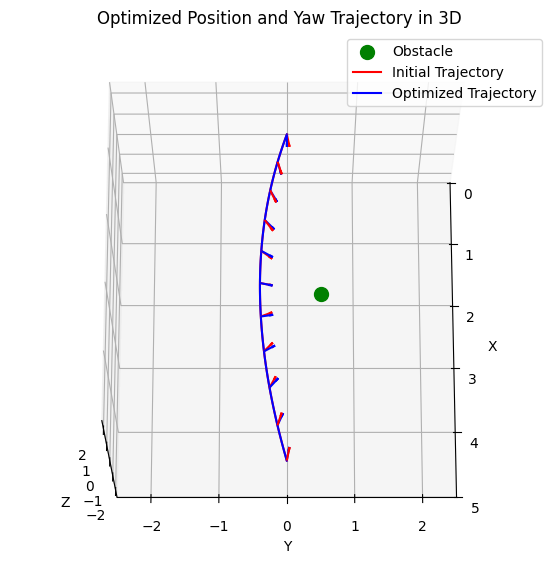

In [45]:
# Create a 3D figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the obstacle in 3D
ax.scatter(obstacle_position[0], obstacle_position[1], obstacle_position[2], color='green', s=100, label='Obstacle')

plot_samples = 100
t_values = np.linspace(0, t_final, plot_samples)

# Plot the initial trajectory using Bezier curves in 3D
# Extract control points for initial trajectory
P0, P1, P2, P3 = initial_pos_control_points
# Evaluate Bezier curve at 100 evenly spaced points
initial_bezier_curve = np.array([cubic_bezier(P0, P1, P2, P3, t) for t in t_values])
# Plot the initial Bezier curve in 3D
ax.plot(initial_bezier_curve[:, 0], initial_bezier_curve[:, 1], initial_bezier_curve[:, 2], 'r-', label='Initial Trajectory')

# Plot the optimized trajectory for cubic bezier curve in 3D
# Extract control points for optimized trajectory
P0, P1, P2, P3 = optimized_pos_control_points
# Evaluate Bezier curve at 100 evenly spaced points
optimized_bezier_curve = np.array([cubic_bezier(P0, P1, P2, P3, t) for t in t_values])
# Plot the optimized Bezier curve in 3D
ax.plot(optimized_bezier_curve[:, 0], optimized_bezier_curve[:, 1], optimized_bezier_curve[:, 2], 'b-', label='Optimized Trajectory')

# Plot desired and optimized attitude vector from the agent to the obstacle
for t in range(0, plot_samples, 10):
    initial_pos_at_t = initial_bezier_curve[t]
    optimized_pos_at_t = cubic_bezier(P0, P1, P2, P3, t_values[t])
    accel_at_t = cubic_bezier_2nd_derivative(P0, P1, P2, P3, t_values[t])
    yaw_at_t = cubic_bezier(optimized_yaw_control_points[0], optimized_yaw_control_points[1], optimized_yaw_control_points[2], optimized_yaw_control_points[3], t_values[t])
    tracking_vector = obstacle_position - initial_pos_at_t
    tracking_vector /= np.linalg.norm(tracking_vector)
    _, attitude_vector = get_attitude_vector(obstacle_position, optimized_pos_at_t, accel_at_t, yaw_at_t)
    ax.quiver(initial_pos_at_t[0], initial_pos_at_t[1], initial_pos_at_t[2], 
              tracking_vector[0], tracking_vector[1], tracking_vector[2], 
              color='red', length=0.2, normalize=True)
    ax.quiver(optimized_pos_at_t[0], optimized_pos_at_t[1], optimized_pos_at_t[2],
                attitude_vector[0], attitude_vector[1], attitude_vector[2],
                color='blue', length=0.2, normalize=True)

# Last point
initial_pos_at_t = initial_bezier_curve[-1]
optimized_pos_at_t = cubic_bezier(P0, P1, P2, P3, t_values[-1])
accel_at_t = cubic_bezier_2nd_derivative(P0, P1, P2, P3, t_values[-1])
yaw_at_t = cubic_bezier(optimized_yaw_control_points[0], optimized_yaw_control_points[1], optimized_yaw_control_points[2], optimized_yaw_control_points[3], t_values[-1])
tracking_vector = obstacle_position - initial_pos_at_t
tracking_vector /= np.linalg.norm(tracking_vector)
_, attitude_vector = get_attitude_vector(obstacle_position, optimized_pos_at_t, accel_at_t, yaw_at_t)
ax.quiver(initial_pos_at_t[0], initial_pos_at_t[1], initial_pos_at_t[2], 
            tracking_vector[0], tracking_vector[1], tracking_vector[2], 
            color='red', length=0.2, normalize=True)
ax.quiver(optimized_pos_at_t[0], optimized_pos_at_t[1], optimized_pos_at_t[2],
            attitude_vector[0], attitude_vector[1], attitude_vector[2],
            color='blue', length=0.2, normalize=True)



# Set labels, title, and show the plot
ax.set_title("Optimized Position and Yaw Trajectory in 3D")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Set axes sizes for better visualization
ax.set_xlim([0, 5])
ax.set_ylim([-2.5, 2.5])
ax.set_zlim([-2.5, 2.5])

# Set view angle for better visualization
ax.view_init(elev=70, azim=0)

plt.show()


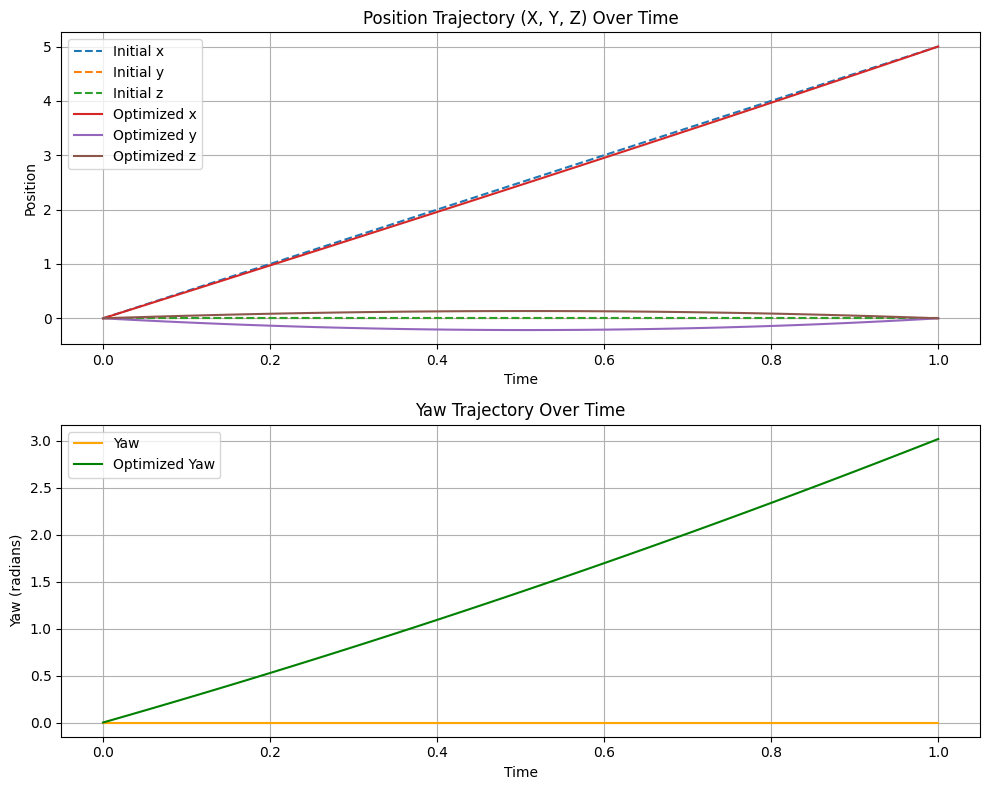

In [5]:

# Evaluate Bezier curve for position (X, Y, Z) over time for initial and optimized control points
initial_position_trajectory = np.array([cubic_bezier(initial_pos_control_points[0], 
                                             initial_pos_control_points[1], 
                                             initial_pos_control_points[2], 
                                             initial_pos_control_points[3], t) for t in t_values])

# Extract X, Y, Z trajectories
initial_x_trajectory = initial_position_trajectory[:, 0]
initial_y_trajectory = initial_position_trajectory[:, 1]
initial_z_trajectory = initial_position_trajectory[:, 2]

optimized_position_trajectory = np.array([cubic_bezier(optimized_pos_control_points[0],
                                                    optimized_pos_control_points[1],
                                                    optimized_pos_control_points[2],
                                                    optimized_pos_control_points[3], t) for t in t_values])

# Extract X, Y, Z trajectories
optimized_x_trajectory = optimized_position_trajectory[:, 0]
optimized_y_trajectory = optimized_position_trajectory[:, 1]
optimized_z_trajectory = optimized_position_trajectory[:, 2]

# Evaluate Bezier curve for yaw over time
initial_yaw_trajectory = np.array([cubic_bezier(initial_yaw_control_points[0], 
                                        initial_yaw_control_points[1], 
                                        initial_yaw_control_points[2], 
                                        initial_yaw_control_points[3], t) for t in t_values])

optimized_yaw_trajectory = np.array([cubic_bezier(optimized_yaw_control_points[0],
                                            optimized_yaw_control_points[1],                           
                                            optimized_yaw_control_points[2],
                                            optimized_yaw_control_points[3], t) for t in t_values])

# Plotting the results
plt.figure(figsize=(10, 8))

# Plot position (X, Y, Z) over time
plt.subplot(2, 1, 1)
plt.plot(t_values, initial_x_trajectory, label='Initial x', linestyle='--')
plt.plot(t_values, initial_y_trajectory, label='Initial y', linestyle='--')
plt.plot(t_values, initial_z_trajectory, label='Initial z', linestyle='--')
plt.plot(t_values, optimized_x_trajectory, label='Optimized x')
plt.plot(t_values, optimized_y_trajectory, label='Optimized y')
plt.plot(t_values, optimized_z_trajectory, label='Optimized z')
plt.title("Position Trajectory (X, Y, Z) Over Time")
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.grid(True)

# Plot yaw over time
plt.subplot(2, 1, 2)
plt.plot(t_values, initial_yaw_trajectory, label='Yaw', color='orange')
plt.plot(t_values, optimized_yaw_trajectory, label='Optimized Yaw', color='green')
plt.title("Yaw Trajectory Over Time")
plt.xlabel('Time')
plt.ylabel('Yaw (radians)')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()